*This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur.
The content is availabe [on GitHub](https://github.com/asabenhur/CS345).*

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*


<a href="https://colab.research.google.com/github//asabenhur/CS345/blob/master/fall24/notebooks/module05_05_multiclass.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Multiclass classification

Until now most of the classifiers we learned can only handle binary classification problems (KNN being the exception).  Let's load our "hello world" iris dataset, which has three classes and run an SVM on it.

In [12]:
import numpy as np
np.set_printoptions(precision=3)

In [13]:
from sklearn import datasets
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score

iris = datasets.load_iris()
X = iris.data
y = iris.target

#classifier = SVC(kernel="linear")
classifier = LinearSVC(loss='hinge', max_iter=50000)

accuracy = cross_val_score(classifier, X, y, cv=5, scoring='accuracy')
print(np.mean(accuracy))

0.9400000000000001


It is doing very well!  How come?  Isn't an SVM a binary classifier?  It certainly is.  However, there are general strategies for converting any binary classifier into a multi-class classifier.  The first is called **one-vs-the-rest** or **one-vs-all**.  

### One-vs-the-rest

To train a one-vs-the-rest classifier on a classification problem with $k$ classes, you train $k$ binary classifiers, one for each binary classification task of distinguishing each class against all the rest.  This leads to $k$ classifiers represented by functions 
$$f_1(\mathbf{x}),\ldots,f_k(\mathbf{x}).$$
To classifier a vector $\mathbf{x}$ you choose the class that receives the highest score, i.e. 
$$\hat{y}(\mathbf{x}) = \underset{i}{\mathrm{arg\,max}}\, f_i(\mathbf{x})$$

To summarize the process:

**Training**

For each class, train a classifier using the class's examples as positives  and all other examples as negatives. 

**Prediction**

Each binary classifier votes for the example being predicted; the predicted class is the one that received the highest score.


Let's demonstrate the one-against-the-rest using the iris dataset:

In [14]:
from sklearn.multiclass import OneVsRestClassifier

classifier = OneVsRestClassifier(LinearSVC(loss='hinge', max_iter=50000))
classifier = OneVsRestClassifier(SVC(kernel="rbf", gamma=1))

accuracy = cross_val_score(classifier, X, y, cv=5, scoring='accuracy')
print(np.mean(accuracy))

0.9666666666666668


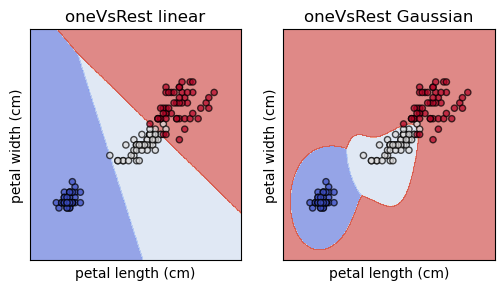

In [4]:
# code adapted from 
# https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html#plot-different-svm-classifiers-in-the-iris-dataset

import matplotlib.pyplot as plt

from sklearn.inspection import DecisionBoundaryDisplay

iris = datasets.load_iris()
X = iris.data
y = iris.target

# focus on the petal length/width features:
X = X[:, [2,3]]

C = 100.0  # SVM regularization parameter
models = (
    OneVsRestClassifier(SVC(kernel="linear", C=C)),
    OneVsRestClassifier(SVC(kernel="rbf", gamma=1, C=C))
)

# train the models:
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = (
    "oneVsRest linear",
    "oneVsRest Gaussian"
)

fig, sub = plt.subplots(1, 2, figsize=(6,3))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]

for clf, title, ax in zip(models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        grid_resolution=500,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.6,
        ax=ax,
        xlabel=iris.feature_names[2],
        ylabel=iris.feature_names[3],
    )
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, alpha=0.7, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)



### One-vs-one

There is an alternative approach called **one-vs-one** in which a classifier is trained on each **pair** of classes.  For predicting a class, an example is run on all the classifiers, and predicted as the class that gets the majority of the votes.

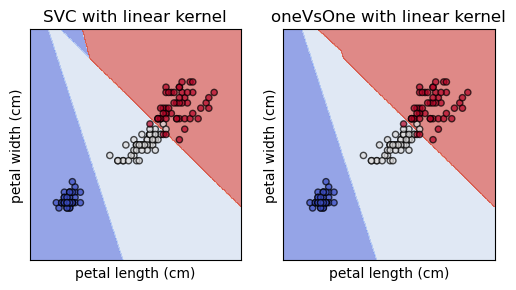

In [5]:
from sklearn.multiclass import OneVsOneClassifier

# code adapted from 
# https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html#plot-different-svm-classifiers-in-the-iris-dataset

import matplotlib.pyplot as plt

from sklearn.inspection import DecisionBoundaryDisplay

iris = datasets.load_iris()
X = iris.data
y = iris.target

# focus on the petal length/width features:
X = X[:, [2,3]]

C = 100.0  # SVM regularization parameter
models = (
    SVC(kernel="linear", C=C),
    OneVsOneClassifier(SVC(kernel="linear", C=C))
)

# train the models:
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = (
    "SVC with linear kernel",
    "oneVsOne with linear kernel"
)

fig, sub = plt.subplots(1, 2, figsize=(6,3))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]

for clf, title, ax in zip(models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        grid_resolution=500,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.6,
        ax=ax,
        xlabel=iris.feature_names[2],
        ylabel=iris.feature_names[3],
    )
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, alpha=0.7, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)



### Multiclass classification of text data

Next, we will look at a more challenging multiclass dataset, the [20 newsgroups](https://archive.ics.uci.edu/dataset/113/twenty+newsgroups)  that is available in scikit-learn using [fetch_20newsgroups](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups_vectorized.html#fetch-20newsgroups-vectorized).

In [6]:
from sklearn.datasets import fetch_20newsgroups_vectorized

# there are separate train and test sets, and it is recommended to remove
# the headers, footers, from the documentation:
# "Each of these are text that will be detected and removed from the newsgroup
# posts, preventing classifiers from overfitting on metadata."

newsgroups_train = fetch_20newsgroups_vectorized(
    subset='train', remove=('headers', 'footers', 'quotes'))
X_train,y_train = newsgroups_train['data'], newsgroups_train['target']
#print(newsgroups_train['DESCR'])

In [7]:
newsgroups_test = fetch_20newsgroups_vectorized(
    subset='test', remove=('headers', 'footers', 'quotes'))
X_test,y_test = newsgroups_test['data'], newsgroups_test['target']

Rather than using the `SVC` class, which we used until now, we will use the `LinearSVC` solver, which is specifically designed for training linear SVMs.

In [8]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

classifier = LinearSVC(loss='hinge', max_iter=5000)
#classifier = SVC(kernel='linear')
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)

np.mean(y_pred == y_test)

0.6549389272437599

This looks kind of low.  However, let's consider what would be the accuracy if we were to simply guess a class.

We can get more information about the performance of the classifier:

In [9]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, 
                            target_names=newsgroups_train['target_names']))

                          precision    recall  f1-score   support

             alt.atheism       0.55      0.39      0.46       319
           comp.graphics       0.63      0.67      0.65       389
 comp.os.ms-windows.misc       0.61      0.59      0.60       394
comp.sys.ibm.pc.hardware       0.65      0.59      0.62       392
   comp.sys.mac.hardware       0.70      0.67      0.69       385
          comp.windows.x       0.78      0.69      0.73       395
            misc.forsale       0.70      0.80      0.75       390
               rec.autos       0.72      0.66      0.69       396
         rec.motorcycles       0.75      0.70      0.72       398
      rec.sport.baseball       0.74      0.77      0.76       397
        rec.sport.hockey       0.79      0.87      0.83       399
               sci.crypt       0.76      0.71      0.73       396
         sci.electronics       0.59      0.50      0.54       393
                 sci.med       0.72      0.76      0.74       396
         

For comparison let's try a nearest neighbor classifier:

In [10]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors = 3)
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)

np.mean(y_pred == y_test)

0.185077004779607

Next week we will cover the random forest classifier, whose performance is often on-par with that of the SVM.  Let's see how it compares here:

In [11]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=200)
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)

np.mean(y_pred == y_test)


0.6112586298459904